# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from matplotlib import style

# Reading CSV file after sampling and before sampling

In [2]:
questions = pd.read_csv('stacksample/Questions.csv', encoding = 'latin1')
tags = pd.read_csv('stacksample/Tags.csv', encoding = 'latin1')

# Merge Two Dataframes

In [3]:
def generate_dataset(df, tag):
    
    data = df.copy(deep=True)
    ta = tag.copy(deep=True)

    ta = ta.astype(str)
    ta = ta.groupby('Id')['Tag'].apply(', '.join).reset_index()
    
    data.Id = data.Id.astype(str)
    ta.Id = ta.Id.astype(str)
    data = pd.merge(data, ta, on='Id')
    data.to_csv('intermediate_dataset/all_data_questions_with_tags.csv', index=False)

    dataframe = data[['Id', 'Title', 'Body', 'Tag']]
    dataframe.to_csv('intermediate_dataset/all_questions_only_with_tags.csv', index=False)
    
    return data, dataframe

# Sampling

In [4]:
def sort_by_date(df):
    
    dataframe = df.copy(deep=True)
    sep = 'T'
    for i in range(dataframe.shape[0]):
        head, sep, tail = dataframe.iloc[i]['CreationDate'].partition(sep)
        dataframe.at[i, 'CreationDate'] = head
    
    sorted_dates = dataframe.sort_values(by='CreationDate')
    
    return sorted_dates

In [5]:
def sampling(df):
    
    dataframe = df.copy(deep=True)
    sample = dataframe[(dataframe['CreationDate'] >= '2014-01-01')].reset_index()
    sample = sample.iloc[:,1:]
    
    return sample

# Train-Test Split

In [6]:
def training_testing_split(df):
    
    dataframe = df.copy(deep=True)
    X_train, X_test, y_train, y_test = train_test_split(df[['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title', 'Body']], df[['Tag']], test_size=0.33, shuffle=False, random_state=0)
    return X_train, X_test, y_train, y_test

# Plot Graphs

In [7]:
def plot_number_tags_per_question(df, df2):
    
    dataframe = df.copy(deep=True)
    dataframe2 = df2.copy(deep=True)
    dataframe['Tag'] = dataframe.Tag.map(lambda x: [i.strip() for i in x.split(",")])
    counts = dataframe.Tag.apply(len)
    occurence = (counts.value_counts(normalize=True).sort_index())
    occurence = occurence.multiply(100)
    
    dataframe2['Tag'] = dataframe2.Tag.map(lambda x: [i.strip() for i in x.split(",")])
    counts2 = dataframe2.Tag.apply(len)
    occurence2 = (counts2.value_counts(normalize=True).sort_index())
    occurence2 = occurence2.multiply(100)
    
    index = ['Whole Dataset', 'Sampled Dataset']
    d = pd.DataFrame([occurence, occurence2], index=index).transpose()

    d.plot.bar()
#     occurence.plot.bar()

    style.use('ggplot')
    plt.grid(True, color='k')
    plt.xlabel('Number Of TAGS')
    plt.ylabel('% Of QUESTIONS')
    plt.title('NUMBER OF TAGS vs QUESTION')
    plt.show()

In [168]:
def plot_top_k_tags(df, ta, k, strs):
    
    dataframe = df.copy(deep=True)
    if strs == 'TOP':
        group = ta.groupby('Tag').size().reset_index(name='counts').sort_values('counts', ascending=False).head(k)
        
    if strs == 'BOTTOM':
        group = ta.groupby('Tag').size().reset_index(name='counts').sort_values('counts', ascending=False).tail(k)
    
    group['counts'] = ((group['counts']*100)/(group['counts'].sum()))
    ls = group['Tag'].values.tolist()
    group.plot.barh(x='Tag', y='counts')
    plt.title(strs+'-15 TAGS ANALYSIS')
    plt.xlabel('% of Tag Occurence')
    plt.ylabel('Tags')
    plt.grid(True, color='k')
    plt.show()
#     frame = dataframe[dataframe.ClosedDate.isnull()]

#     dataframe.Id = dataframe.Id.astype(str)
#     ta.Id = ta.Id.astype(str)
#     data = pd.merge(ta, dataframe, on='Id')
#     print(frame.shape)
# #     print(data)
#     fr = ta[ta.Tag.isin(frame.Tag)]
#     print(fr.shape, 'frshape')
#     return fr, frame
    return ls

In [169]:
def plot_growth_of_tags(df, str1, str2, word):
    
    dataframe = df.copy(deep=True)
    
#     dataframe['CreationDate'] = pd.to_datetime(dataframe['CreationDate'])
    
    sorted_d = dataframe.sort_values(by='CreationDate')
    sample = sorted_d[(sorted_d['CreationDate'] >= str1) & (sorted_d['CreationDate'] <= str2)]
    s = sample.copy(deep=True)
#     print(sample)
    data = \
    (sample.set_index(sample.columns.drop('Tag', 1).tolist())
     .Tag.str.split(',', expand=True)
     .stack()
     .reset_index()
     .rename(columns={len(sample.columns)-1:'Tag'})
     .loc[:, sample.columns]
    )
   
    datas = s['Tag'].str.split(',').apply(pd.Series, 1).stack()
    datas.index = datas.index.droplevel(-1)
    datas.name = 'Tag'
    f = pd.DataFrame(datas)
    print(f.shape, data.shape)
    f.reset_index(drop=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
#     print(datas)
    frame = pd.concat([data, f], axis=1, ignore_index=True)
    
    frame = frame[[0, 8]]
    dictionary = frame[8].value_counts().to_dict()
    
    return dictionary[word]
# #     print(data.reset_index())
#     data = data['Tag'].reset_index()
#     print(data)
#     sample = sample.loc[:, sample.columns!='Tag']
#     sample = pd.concat([sample, data], axis=1)
#     print(sample)
#     data = pd.merge(sample, ta, on='Id', how='left', validate='one_to_many')
#     print(data)
#     frame = dataframe.groupby(dataframe['CreationDate'].map(lambda x: x.year))
#     print(frame.get_group('2015'))
    
#     for name in frame:
# #         print(name)
#         print(name['Id'])

In [9]:
full_data, tag_questions = generate_dataset(questions, tags)

In [10]:
sorted_date = sort_by_date(full_data)
sampled_data = sampling(sorted_date)

In [11]:
X_train, X_test, y_train, y_test = training_testing_split(sampled_data)

In [12]:
training_set = pd.concat([X_train, y_train], axis=1)
testing_set = pd.concat([X_test, y_test], axis=1)
print(training_set.shape)
print(testing_set.shape)
training_set.to_csv('intermediate_dataset/training_set.csv', index=False)
testing_set.to_csv('intermediate_dataset/testing_set.csv', index=False)

(441368, 8)
(217391, 8)


In [13]:
training_tag = training_set[['Id', 'Title', 'Body', 'Tag']]
testing_tag = testing_set[['Id', 'Title', 'Body', 'Tag']]
training_set.to_csv('intermediate_dataset/tags_training.csv', index=False)
testing_set.to_csv('intermediate_dataset/tags_testing.csv', index=False)

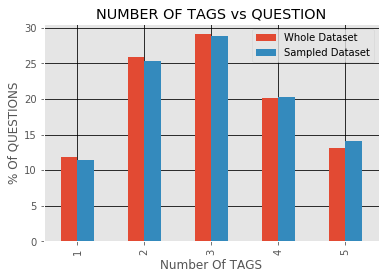

In [35]:
# plot_number_tags_per_question(full_data, 'Whole Dataset')
# plot_number_tags_per_question(sampled_data, 'Sampled Dataset')

plot_number_tags_per_question(full_data, sampled_data)

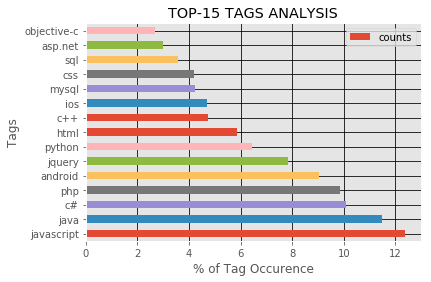

['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', 'c++', 'ios', 'mysql', 'css', 'sql', 'asp.net', 'objective-c']


In [109]:
top_tags = plot_top_k_tags(sampled_data, tags, 15, 'TOP')
print(top_tags)

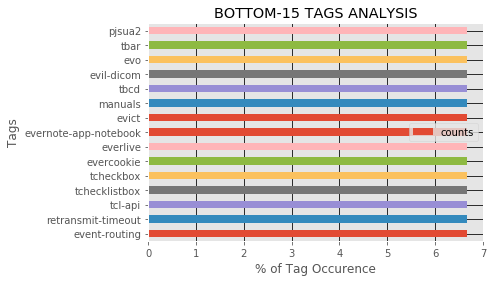

['event-routing', 'retransmit-timeout', 'tcl-api', 'tchecklistbox', 'tcheckbox', 'evercookie', 'everlive', 'evernote-app-notebook', 'evict', 'manuals', 'tbcd', 'evil-dicom', 'evo', 'tbar', 'pjsua2']


In [163]:
bottom_tags = plot_top_k_tags(sampled_data, tags, 15, 'BOTTOM')
print(bottom_tags)

hell


c:\python\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[23514, 26283, 24604]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[21828, 22394, 18607]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[16421, 15788, 13353]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[16332, 15481, 13540]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[12869, 13130, 12238]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[4845, 3933, 2875]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[11410, 13667, 13795]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[4460, 4680, 4027]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[7984, 7744, 6083]
hell
(653485, 1) (653485, 8)
(693626, 1) (693626, 8)
(631280, 1) (631280, 8)
[8578, 9618, 7613]
hell
(653485, 1) (653485, 8

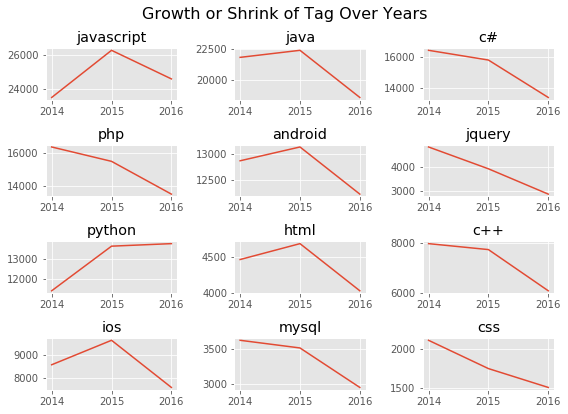

In [185]:
year = [2014, 2015, 2016]
fig = plt.figure(figsize=(8,6))
fig.suptitle('Growth or Shrink of Tag Over Years', fontsize=16)
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(len(top_tags)-3):
    ls = []
    print('hell')
    c1 = plot_growth_of_tags(sampled_data, '2014-01-01', '2014-12-31', top_tags[i])
    c2 = plot_growth_of_tags(sampled_data, '2015-01-01', '2015-12-31', top_tags[i])
    c3 = plot_growth_of_tags(sampled_data, '2016-01-01', '2016-12-31', top_tags[i])
    ls.append(c1)
    ls.append(c2)
    ls.append(c3)
    print(ls)
    ax = fig.add_subplot(4,3,i+1)
    ax.plot(year, ls)
    ax.set_title(top_tags[i])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

hell


c:\python\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(16812, 1) (16812, 8)
(98518, 1) (98518, 8)
(201067, 1) (201067, 8)
(352908, 1) (352908, 8)
(488521, 1) (488521, 8)
(611242, 1) (611242, 8)
(652273, 1) (652273, 8)
(692259, 1) (692259, 8)
(631280, 1) (631280, 8)
[219, 1565, 3762, 8245, 12316, 18214, 23471, 26217, 24604]
hell
(16812, 1) (16812, 8)
(98518, 1) (98518, 8)
(201067, 1) (201067, 8)
(352908, 1) (352908, 8)
(488521, 1) (488521, 8)
(611242, 1) (611242, 8)
(652273, 1) (652273, 8)
(692259, 1) (692259, 8)
(631280, 1) (631280, 8)
[407, 2319, 5370, 9692, 14387, 19111, 21791, 22360, 18607]
hell
(16812, 1) (16812, 8)
(98518, 1) (98518, 8)
(201067, 1) (201067, 8)
(352908, 1) (352908, 8)
(488521, 1) (488521, 8)
(611242, 1) (611242, 8)
(652273, 1) (652273, 8)
(692259, 1) (692259, 8)
(631280, 1) (631280, 8)
[680, 4593, 7585, 11294, 13814, 16571, 16392, 15757, 13353]
hell
(16812, 1) (16812, 8)
(98518, 1) (98518, 8)
(201067, 1) (201067, 8)
(352908, 1) (352908, 8)
(488521, 1) (488521, 8)
(611242, 1) (611242, 8)
(652273, 1) (652273, 8)
(692259

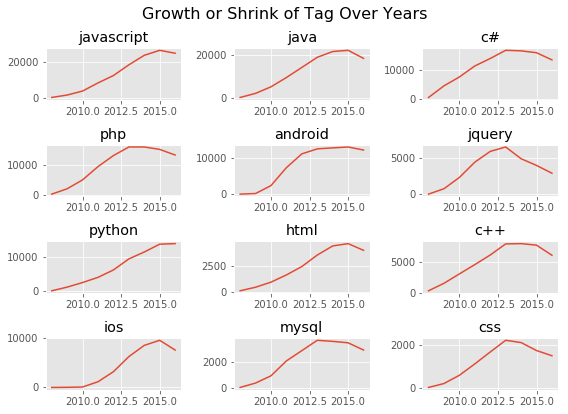

In [189]:
year = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
fig = plt.figure(figsize=(8,6))
fig.suptitle('Growth or Shrink of Tag Over Years', fontsize=16)
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(len(top_tags)-3):
    ls = []
    print('hell')
    c1 = plot_growth_of_tags(full_data, '2008-01-01', '2008-12-31', top_tags[i])
    c2 = plot_growth_of_tags(full_data, '2009-01-01', '2009-12-31', top_tags[i])
    c3 = plot_growth_of_tags(full_data, '2010-01-01', '2010-12-31', top_tags[i])
    c4 = plot_growth_of_tags(full_data, '2011-01-01', '2011-12-31', top_tags[i])
    c5 = plot_growth_of_tags(full_data, '2012-01-01', '2012-12-31', top_tags[i])
    c6 = plot_growth_of_tags(full_data, '2013-01-01', '2013-12-31', top_tags[i])
    c7 = plot_growth_of_tags(full_data, '2014-01-01', '2014-12-31', top_tags[i])
    c8 = plot_growth_of_tags(full_data, '2015-01-01', '2015-12-31', top_tags[i])
    c9 = plot_growth_of_tags(full_data, '2016-01-01', '2016-12-31', top_tags[i])
    ls.append(c1)
    ls.append(c2)
    ls.append(c3)
    ls.append(c4)
    ls.append(c5)
    ls.append(c6)
    ls.append(c7)
    ls.append(c8)
    ls.append(c9)
    print(ls)
    ax = fig.add_subplot(4,3,i+1)
    ax.plot(year, ls)
    ax.set_title(top_tags[i])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [191]:
questions.shape

(1264216, 7)

In [192]:
tags.shape

(3750994, 2)